# Gradient learning for multilayer perceptron

The notebook objectives are to learn how to:
1. Use`nn.Sequential` to chain layers.
This is quick and easy for multilayer networks, though it becomes less convenient to look inside the network.
2. Expose hidden layer activities by registering hooks. Hooks are the way to look inside the network, for visualization and debugging.
3. View the deltas of the backward pass, which are in the bias gradients.

In [1]:
%pip install --upgrade matplotlib      # to make subfigures work on Colab. You'll need to restart runtime afterwards.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import numpy as np

# display plots inline (in the notebook rather than another window)
%matplotlib inline

#plt.rcParams['image.cmap'] = 'gray'

plt.rcParams['image.cmap'] = 'hot'

torch.manual_seed(485)        # manually seed the random number generator (useful if you want reproducible experiments)

## Load the training data and define visualization functions

In [3]:
mnist = datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets

tmax, nrow, ncol = trainimages.size()
nclass = len(torch.unique(trainlabels))    # number of classes

100%|██████████| 9912422/9912422 [00:00<00:00, 146117064.72it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 73908293.97it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66567443.39it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2898741.44it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
def montage(fig, imgstack):
    nimg = imgstack.size(dim = 0)
    width = int(np.ceil(np.sqrt(nimg)))   # compute a roughly square layout for the panels
    height = int(np.ceil(nimg / width))
    for i in range(nimg):
        ax = fig.add_subplot(height, width, i+1)
        ax.matshow(imgstack[i])
        ax.axis('off')

def movingaverage(input, windowsize):        # moving average
    output = np.convolve(input, np.ones(windowsize)/windowsize, mode ='valid')
    return np.pad(output, (windowsize - 1, 0))     # output is zero until windowsize inputs have been seen

def viz(fig, activity, delta, errcl, entropy, weight):
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    ax = subfigs[0].add_subplot(2, 2, 1)
    ax.bar(range(len(activity)), activity)
    ax.set_title("x1")

    ax = subfigs[0].add_subplot(2, 2, 2)
    ax.bar(range(len(delta)), delta)
    ax.set_title("delta1")

    ax = subfigs[0].add_subplot(2, 2, 3)
    ax.plot(movingaverage(errcl, 50))
    ax.set_title("classification error")

    ax = subfigs[0].add_subplot(2, 2, 4)
    ax.plot(movingaverage(entropy, 50))
    ax.set_title("cross entropy loss")

    montage(subfigs[1], weight.view(-1, nrow, ncol))

    display.clear_output(wait=True)
    display.display(fig)
    fig.clf()

## Define the architecture of the two-layer perceptron
There is no nonlinear activation function at the end, because the softmax will be implicit in the loss function.\
The network width is controlled through `n1`, the size of the hidden layer.\
You can make the network deeper by adding `nn.ReLU` and `nn.Linear` layers.

In [5]:
n1 = 25   # size of hidden layer
model = nn.Sequential(
            nn.Linear(nrow*ncol, n1),
            nn.ReLU(),
            nn.Linear(n1, nclass)
        )
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=25, bias=True)
  (1): ReLU()
  (2): Linear(in_features=25, out_features=10, bias=True)
)


### Access weights and biases

In [6]:
model[0].weight    # weight matrix of the first linear layer

Parameter containing:
tensor([[-0.0231, -0.0059, -0.0312,  ...,  0.0234,  0.0147,  0.0110],
        [ 0.0356, -0.0135, -0.0291,  ..., -0.0129,  0.0240,  0.0058],
        [-0.0022, -0.0295,  0.0269,  ..., -0.0123,  0.0294, -0.0134],
        ...,
        [-0.0338,  0.0317, -0.0304,  ...,  0.0313,  0.0252, -0.0345],
        [-0.0284,  0.0020, -0.0070,  ..., -0.0007,  0.0112, -0.0145],
        [-0.0017, -0.0219,  0.0161,  ...,  0.0077, -0.0097,  0.0188]],
       requires_grad=True)

In [7]:
model[2].bias   # biases of the second linear layer

Parameter containing:
tensor([ 0.1825,  0.1556, -0.0926, -0.1128,  0.0704,  0.1643, -0.1925, -0.0765,
        -0.1193,  0.1531], requires_grad=True)

### Register a hook to expose the activity of the hidden layer.
`nn.Sequential` is convenient but hides the activities of hidden layers.\
The activities can be exposed through hooks.\
`activations` is a dictionary that will store the activity during each forward pass of the model.

In [8]:
activations = {}
def hook(model, input, output):
    activations['x1'] = output
h1 = model[1].register_forward_hook(hook)

### Apply the network to the first image in the training set

In [9]:
x0 = trainimages[0].view(-1)/255
model(x0)

tensor([ 0.2370,  0.1058, -0.0648, -0.0847,  0.1204,  0.1967, -0.1318, -0.0428,
        -0.1304,  0.0334], grad_fn=<ViewBackward0>)

In [10]:
activations['x1']    # the activities of the hidden layer as exposed by the hook

tensor([0.0126, 0.2253, 0.0457, 0.2787, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.1449, 0.1402, 0.0000, 0.0128, 0.0000, 0.0580, 0.1118, 0.0000, 0.0970,
        0.0000, 0.1687, 0.0000, 0.0000, 0.1084, 0.0000, 0.0000],
       grad_fn=<ReluBackward0>)

In [11]:
model[0].weight @ x0 + model[0].bias   # Rectifying these values yields the activities in the previous cell

tensor([ 0.0126,  0.2253,  0.0457,  0.2787, -0.5057, -0.3578, -0.4044, -0.0325,
        -0.1221,  0.1449,  0.1402, -0.1309,  0.0128, -0.3547,  0.0580,  0.1118,
        -0.4374,  0.0970, -0.2862,  0.1687, -0.0754, -0.1294,  0.1084, -0.2187,
        -0.0782], grad_fn=<AddBackward0>)

## Training

### Uncomment this code block to explore a really bad initialization (all parameters set to zero).

In [12]:
with torch.no_grad():
   for p in model.parameters():
       p *= 0

#with torch.no_grad():
#   for p in model[2].parameters():
#       p *= 0

### Define arrays to track learning curves

In [13]:
errcl = torch.zeros(tmax)    # classification error vs. time
entropy = torch.zeros(tmax)   # cross entropy loss vs. time

tshow = 1000   # how often to pause and plot
eta = 0.01  # learning rate parameter (controls length of gradient step)

### The main training loop

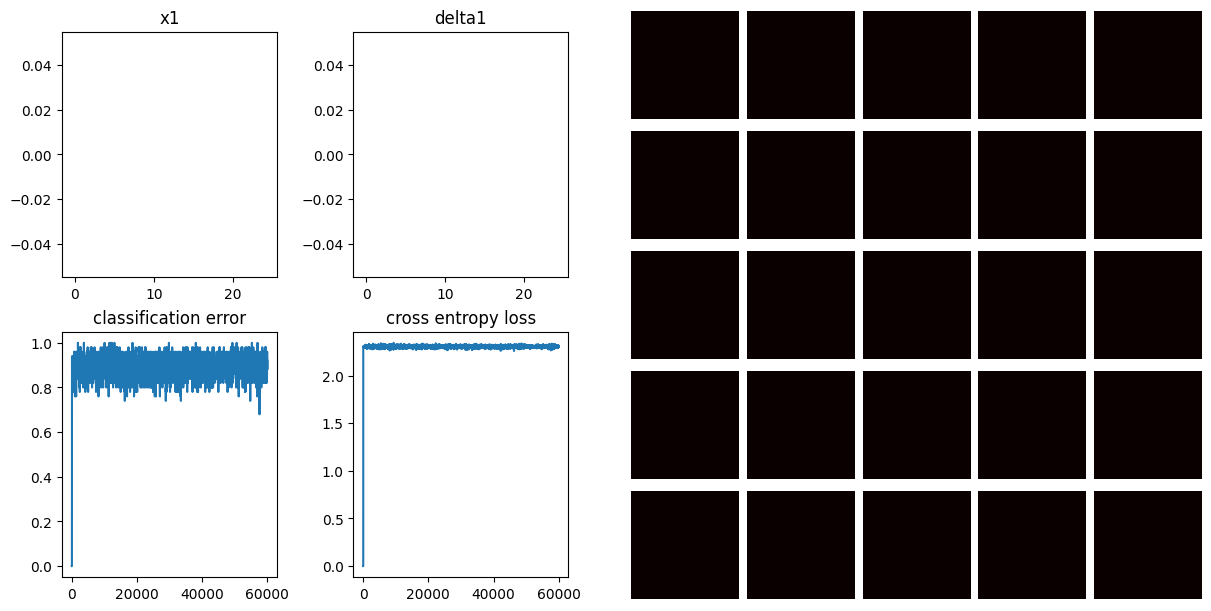

<Figure size 1200x600 with 0 Axes>

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))

for t in range(tmax):
    x0 = trainimages[t].view(-1)/255    # reshape image into a vector, and normalize to range [0, 1]
    logit = model(x0)                  # preactivity of softmax

    desired = F.one_hot(trainlabels[t], 10).float()  # convert label into one-hot vector for desired output i.e. target vector
    loss = F.cross_entropy(logit, desired)    # combines softmax and cross entropy loss
    loss.backward()                          # the backward pass computes gradients

    x1 = activations['x1']             # activity of hidden layer was stored by the forward hook
    delta1 = -model[0].bias.grad       # deltas of the backward pass are in the bias gradients

    with torch.no_grad():
        errcl[t] = torch.max(logit, 0).indices.item() != trainlabels[t]
        entropy[t] = loss
        for p in model.parameters():
           p -= p.grad * eta
           p.grad.zero_()          # All gradients should be zeroed after the update. Otherwise they will accumulate.

    if (t+1) % tshow == 0:
        print(model[0].weight)
        print(model[0].bias)
        print(model[2].weight)
        print(model[2].bias)
        print(f't={t+1:d} loss={torch.mean(entropy[t-tshow+1:t+1]):f}')  # loss averaged over last tshow examples
        viz(fig, x1.detach(), delta1.detach(), errcl[:t].detach(), entropy[:t].detach(), model[0].weight.detach())

## You've finished the notebook...congrats!
The above code can be improved by:
1. Switching to minibatch training using the `DataLoader`
2. Using `torch.optim` for adaptive learning rate, momentum, etc.
3. Moving the computation to the GPU.
    
These topics are covered in the [PyTorch Quickstart](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

To use a GPU in Google Colab, select Runtime > Change runtime type
You'll get a popup, and click on the "Hardware accelerator" dropdown to select "GPU".